# Training

## Part 1 

In [1]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [3]:
train_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.49, 0.248),
                                transforms.RandomAffine(degrees=(-5, 5),
                                                        translate=(0, 0.05),
                                                        scale=(0.9, 1.1)),
                                transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
])

val_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.49, 0.248)
])

In [4]:
train_dataset = torchvision.datasets.DatasetFolder('Data/Pneumonia/Processed/train/',
                                                   loader=load_file,
                                                   extensions='npy',
                                                   transform=train_transforms)
val_dataset = torchvision.datasets.DatasetFolder('Data/Pneumonia/Processed/val/',
                                                 loader=load_file,
                                                 extensions='npy',
                                                 transform=val_transforms)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Data/Pneumonia/Processed/train/'

NameError: name 'train_dataset' is not defined

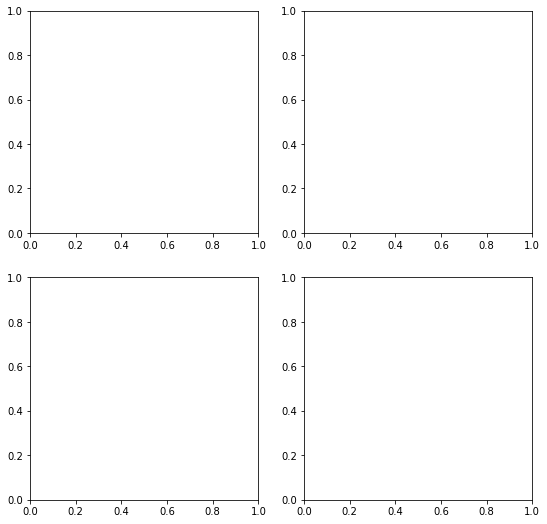

In [5]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))

for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 24000)
        
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap='bone')
        axis[i][j].set_title(label)

In [7]:
batch_size = 64
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=False)

NameError: name 'train_dataset' is not defined

In [8]:
np.unique(train_dataset.targets, return_counts=True)

NameError: name 'train_dataset' is not defined

## Part 2

In [9]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
class PneumoniaModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        
        # adapt model
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))
        
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
    
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    
    # define training_step, otherwise pl will throw an error
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        
        self.log('Train loss', loss)
        self.log('Step Train ACC', self.train_acc(torch.sigmoid(pred), label.int()))
        
        return loss
    
    
    def training_epoch_end(self, outs):
        self.log('Train ACC', self.train_acc.compute())
    
    
    # define validation_step, otherwise pl will throw an error
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        
        self.log('Val loss', loss)
        self.log('Step Val ACC', self.val_acc(torch.sigmoid(pred), label.int()))
        
        return loss
    
    
    def validation_epoch_end(self, outs):
        self.log('Val ACC', self.val_acc.compute())
    
    
    def configure_optimizers(self):
        return [self.optimizer]


## Part 3

In [16]:
model = PneumoniaModel()

In [17]:
checkpoint_callback = ModelCheckpoint(monitor='Val ACC',
                                      save_top_k=10,
                                      mode='max')

In [18]:
gpus = 1
trainer = pl.Trainer(gpus=gpus,
                     logger=TensorBoardLogger(save_dir='Data/Pneumonia/logs'),
                     log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=35)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [19]:
trainer.fit(model, train_loader, val_loader)

NameError: name 'train_loader' is not defined

## Part 4

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = PneumoniaModel.load_from_checkpoint('../04-Pneumonia-Classification/weights/weights_3.ckpt')
model.eval()
model.to(device)

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [21]:
preds = []
labels = []

# no neccessary gardinets --> raw prediction
with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        
        preds.append(pred)
        labels.append(label)

preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

NameError: name 'val_dataset' is not defined

In [22]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)

print(f'Val Accuracy {acc}')
print(f'Val Precision {precision}')
print(f'Val Recall {recall}')
print(f'Confusion Matrix {cm}')

AttributeError: 'list' object has no attribute 'is_floating_point'